In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import os 

import shap
import xgboost as xgb
from sklearn.metrics import mean_squared_error

/Users/afsinozdemir/anaconda3/envs/NewAtlantisPro/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading O2 

In [2]:
o2_path = 'data/daily_data/o2_raw'
o2_list = os.listdir(o2_path)

df_o2 = pd.DataFrame()

for day in o2_list:
    day_path = os.path.join(o2_path, day)
    df_temp = pd.read_csv(day_path)

    df_o2 = pd.concat([df_o2,df_temp])

df_o2.drop(columns='Unnamed: 0', inplace=True)
df_o2

,date,lon_rounded_up,lat_rounded_up,depth,o2
0,2023-12-12,-95,-10,0.494025,219.067394
1,2023-12-12,-95,-10,1.541375,219.071041
2,2023-12-12,-95,-10,2.645669,219.074651
3,2023-12-12,-95,-10,3.819495,219.078208
4,2023-12-12,-95,-10,5.078224,219.081724
...,...,...,...,...,...
3595,2023-12-21,0,35,25.211409,NaN
3596,2023-12-21,0,35,29.444729,NaN
3597,2023-12-21,0,35,34.434155,NaN
3598,2023-12-21,0,35,40.344050,NaN


In [3]:
df_o2.sort_values('date')

,date,lon_rounded_up,lat_rounded_up,depth,o2
0,2021-11-01,-95,-10,0.494025,225.266964
2394,2021-11-01,-30,5,0.494025,204.284362
2395,2021-11-01,-30,5,1.541375,204.356393
2396,2021-11-01,-30,5,2.645669,204.427844
2397,2021-11-01,-30,5,3.819495,204.489955
...,...,...,...,...,...
2395,2024-03-31,-30,5,1.541375,202.297220
2394,2024-03-31,-30,5,0.494025,202.279153
2393,2024-03-31,-30,0,47.373688,206.242765
2363,2024-03-31,-30,-5,6.440614,196.159393


In [4]:
df_o2.rename(columns={'lon_rounded_up':'lon','lat_rounded_up':'lat'}, inplace=True)

# Reading CHL, nitrate, phosphate, silicate

In [13]:
chl_nit_posh_path = 'data/daily_data/geo_raw'
chl_nit_posh_list = os.listdir(chl_nit_posh_path)

In [14]:
chl_nit_posh_path = 'data/daily_data/geo_raw'
chl_nit_posh_list = os.listdir(chl_nit_posh_path)
chl_nit_posh_list.remove('readme.txt')

df_chl_nit_posh = pd.DataFrame()


for day in chl_nit_posh_list:

    day_path = os.path.join(chl_nit_posh_path, day)
    df_temp = pd.read_csv(day_path)

    df_chl_nit_posh = pd.concat([df_chl_nit_posh,df_temp])

    
df_chl_nit_posh

,longitude_bins,latitude_bins,time,depth,chl,no3,po4,si
0,0,0,2021-11-30,0.494025,0.149859,2.325064,0.826761,3.878553
1,0,0,2021-11-30,1.541375,0.149860,2.325051,0.826756,3.878534
2,0,0,2021-11-30,2.645669,0.149862,2.325067,0.826752,3.878516
3,0,0,2021-11-30,3.819495,0.149865,2.325118,0.826746,3.878498
4,0,0,2021-11-30,5.078224,0.149870,2.325200,0.826739,3.878478
...,...,...,...,...,...,...,...,...
662395,19,9,2023-11-30,25.211409,NaN,NaN,NaN,NaN
662396,19,9,2023-11-30,29.444729,NaN,NaN,NaN,NaN
662397,19,9,2023-11-30,34.434155,NaN,NaN,NaN,NaN
662398,19,9,2023-11-30,40.344050,NaN,NaN,NaN,NaN


In [15]:
bin_to_latitude = {
    0: -15,
    1: -10,
    2: -5,
    3: 0,
    4: 5,
    5: 10,
    6: 15,
    7: 20,
    8: 25,
    9: 30
}

df_chl_nit_posh['lat'] = df_chl_nit_posh['latitude_bins'].map(bin_to_latitude)

In [16]:
bin_to_longitude = {
    0: -100,
    1: -95,
    2: -90,
    3: -85,
    4: -80,
    5: -75,
    6: -70,
    7: -65,
    8: -60,
    9: -55,
    10: -50,
    11: -45,
    12: -40,
    13: -35,
    14: -30,
    15: -25,
    16: -20,
    17: -15,
    18: -10,
    19: -5,
}

df_chl_nit_posh['lon'] = df_chl_nit_posh['longitude_bins'].map(bin_to_longitude)

In [17]:
df_chl_nit_posh.drop(columns=['longitude_bins','latitude_bins'], inplace=True)
df_chl_nit_posh

,time,depth,chl,no3,po4,si,lat,lon
0,2021-11-30,0.494025,0.149859,2.325064,0.826761,3.878553,-15,-100
1,2021-11-30,1.541375,0.149860,2.325051,0.826756,3.878534,-15,-100
2,2021-11-30,2.645669,0.149862,2.325067,0.826752,3.878516,-15,-100
3,2021-11-30,3.819495,0.149865,2.325118,0.826746,3.878498,-15,-100
4,2021-11-30,5.078224,0.149870,2.325200,0.826739,3.878478,-15,-100
...,...,...,...,...,...,...,...,...
662395,2023-11-30,25.211409,NaN,NaN,NaN,NaN,30,-5
662396,2023-11-30,29.444729,NaN,NaN,NaN,NaN,30,-5
662397,2023-11-30,34.434155,NaN,NaN,NaN,NaN,30,-5
662398,2023-11-30,40.344050,NaN,NaN,NaN,NaN,30,-5


In [18]:
df_posh = df_chl_nit_posh[['time','lat','lon','depth','po4']]
df_posh

,time,lat,lon,depth,po4
0,2021-11-30,-15,-100,0.494025,0.826761
1,2021-11-30,-15,-100,1.541375,0.826756
2,2021-11-30,-15,-100,2.645669,0.826752
3,2021-11-30,-15,-100,3.819495,0.826746
4,2021-11-30,-15,-100,5.078224,0.826739
...,...,...,...,...,...
662395,2023-11-30,30,-5,25.211409,NaN
662396,2023-11-30,30,-5,29.444729,NaN
662397,2023-11-30,30,-5,34.434155,NaN
662398,2023-11-30,30,-5,40.344050,NaN


In [19]:
df_posh.rename(columns={'time':'date'}, inplace=True)

/var/folders/hr/s8vh2tdj11s6hjxcsw2lr01m0000gn/T/ipykernel_39892/3499303785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posh.rename(columns={'time':'date'}, inplace=True)


In [20]:
df_posh

,date,lat,lon,depth,po4
0,2021-11-30,-15,-100,0.494025,0.826761
1,2021-11-30,-15,-100,1.541375,0.826756
2,2021-11-30,-15,-100,2.645669,0.826752
3,2021-11-30,-15,-100,3.819495,0.826746
4,2021-11-30,-15,-100,5.078224,0.826739
...,...,...,...,...,...
662395,2023-11-30,30,-5,25.211409,NaN
662396,2023-11-30,30,-5,29.444729,NaN
662397,2023-11-30,30,-5,34.434155,NaN
662398,2023-11-30,30,-5,40.344050,NaN


# Salinity Reading 

In [21]:
salinity_path = 'data/daily_data/Salinity_data'
salinity_list = os.listdir(salinity_path)
salinity_list

['Salinity_220601-240825_p8.csv',
 '.DS_Store',
 'Salinity_220601-240825_p7.csv',
 'Salinity_220601-240825_p6.csv',
 'Salinity_220601-240825_p4.csv',
 'Salinity_220601-240825_p5.csv',
 'Salinity_220601-240825_p1.csv',
 'Salinity_211101-220601_p1.csv',
 'Salinity_220601-240825_p2.csv',
 'Salinity_211101-220601_p2.csv',
 'Salinity_220601-240825_p3.csv']

In [22]:
salinity_path = 'data/daily_data/Salinity_data'
salinity_list = os.listdir(salinity_path)

salinity_list.remove('.DS_Store')


df_salinity = pd.DataFrame()

for parts in salinity_list:
    parts_path = os.path.join(salinity_path,parts)

    df_temp = pd.read_csv(parts_path)

    df_salinity = pd.concat([df_salinity,df_temp])

df_salinity.rename(columns={'longitude':'lon','latitude':'lat','time':'date'}, inplace=True)

df_salinity

,lon,lat,date,depth,Salinity
0,-50.0,-15.0,2022-11-07,7.929560,NaN
1,-50.0,-15.0,2022-11-07,9.572997,NaN
2,-50.0,-15.0,2022-11-07,11.405000,NaN
3,-50.0,-15.0,2022-11-07,13.467140,NaN
4,-50.0,-15.0,2022-11-07,15.810070,NaN
...,...,...,...,...,...
419996,-85.0,25.0,2023-01-16,29.444730,36.137830
419997,-85.0,25.0,2023-01-16,34.434150,36.172150
419998,-85.0,25.0,2023-01-16,40.344050,36.204120
419999,-85.0,25.0,2023-01-16,47.373690,36.216965


In [23]:
df_salinity.sort_values('date')

,lon,lat,date,depth,Salinity
3886,-25.0,20.0,2021-11-01,22.757616,36.793316
4109,-75.0,10.0,2021-11-01,22.757616,35.432365
4110,-85.0,20.0,2021-11-01,2.667682,36.255850
4111,-85.0,20.0,2021-11-01,1.555855,36.256400
4112,-15.0,-5.0,2021-11-01,41.180023,35.956110
...,...,...,...,...,...
274160,-75.0,25.0,2024-08-25,2.645669,36.559937
274159,-75.0,25.0,2024-08-25,1.541375,36.558876
274158,-75.0,25.0,2024-08-25,0.494025,36.558067
8397,-55.0,-15.0,2024-08-25,34.434150,NaN


In [24]:
df_salinity['lon'].nunique()

21

# Reading Temp

In [25]:
temp_path = 'data/daily_data/Temp'
temp_list = os.listdir(temp_path)
temp_list

['Temp_220601-240825_p8.csv',
 'Temp_220601-240825_p6.csv',
 'Temp_220601-240825_p7.csv',
 'Temp_220601-240825_p5.csv',
 'Temp_220601-240825_p4.csv',
 'Temp_211101-220601_p1.csv',
 'Temp_220601-240825_p1.csv',
 'Temp_220601-240825_p3.csv',
 'Temp_211101-220601_p2.csv',
 'Temp_220601-240825_p2.csv']

In [26]:
temp_path = 'data/daily_data/Temp'
temp_list = os.listdir(temp_path)



df_temperature = pd.DataFrame()

for parts in temp_list:
    parts_path = os.path.join(temp_path,parts)

    df_temp = pd.read_csv(parts_path)

    df_temperature = pd.concat([df_temperature,df_temp])

df_temperature


,longitude,latitude,time,depth,temp
0,-30.0,-15.0,2024-05-04,0.494025,29.036638
1,-80.0,30.0,2024-05-04,1.541375,24.727770
2,-80.0,30.0,2024-05-04,2.645669,24.679865
3,-80.0,30.0,2024-05-04,3.819495,24.601017
4,-80.0,30.0,2024-05-04,5.078224,24.505013
...,...,...,...,...,...
419996,-50.0,15.0,2022-12-20,18.495560,26.372103
419997,-50.0,15.0,2022-12-20,15.810070,26.371681
419998,-50.0,15.0,2022-12-20,13.467140,26.371672
419999,-50.0,15.0,2022-12-20,11.405000,26.371754


In [27]:
df_temperature.rename(columns={'longitude':'lon','latitude':'lat','time':'date'}, inplace=True)


df_temperature

,lon,lat,date,depth,temp
0,-30.0,-15.0,2024-05-04,0.494025,29.036638
1,-80.0,30.0,2024-05-04,1.541375,24.727770
2,-80.0,30.0,2024-05-04,2.645669,24.679865
3,-80.0,30.0,2024-05-04,3.819495,24.601017
4,-80.0,30.0,2024-05-04,5.078224,24.505013
...,...,...,...,...,...
419996,-50.0,15.0,2022-12-20,18.495560,26.372103
419997,-50.0,15.0,2022-12-20,15.810070,26.371681
419998,-50.0,15.0,2022-12-20,13.467140,26.371672
419999,-50.0,15.0,2022-12-20,11.405000,26.371754


In [28]:
df_o2

,date,lon,lat,depth,o2
0,2023-12-12,-95,-10,0.494025,219.067394
1,2023-12-12,-95,-10,1.541375,219.071041
2,2023-12-12,-95,-10,2.645669,219.074651
3,2023-12-12,-95,-10,3.819495,219.078208
4,2023-12-12,-95,-10,5.078224,219.081724
...,...,...,...,...,...
3595,2023-12-21,0,35,25.211409,NaN
3596,2023-12-21,0,35,29.444729,NaN
3597,2023-12-21,0,35,34.434155,NaN
3598,2023-12-21,0,35,40.344050,NaN


In [29]:
df_list = [df_salinity,df_temperature, df_posh]

In [30]:
# df_all = df_o2

# for df_predictor in df_list:

#     df_all = df_all.merge(df_predictor, how='left', on='date')

# df_all

In [31]:
df_all = df_o2.merge(df_salinity, how='outer')

In [32]:
df_all = df_all.merge(df_temperature, how='outer')

In [33]:
df_all = df_all.merge(df_posh, how='outer')
df_all

,date,lon,lat,depth,o2,Salinity,temp,po4
0,2021-11-01,-100.0,-15.0,0.505760,NaN,35.627200,21.621576,NaN
1,2021-11-01,-100.0,-15.0,1.555855,NaN,35.627083,21.619543,NaN
2,2021-11-01,-100.0,-15.0,2.667682,NaN,35.626846,21.614853,NaN
3,2021-11-01,-100.0,-15.0,3.856280,NaN,35.626534,21.608278,NaN
4,2021-11-01,-100.0,-15.0,5.140361,NaN,35.626213,21.601225,NaN
...,...,...,...,...,...,...,...,...
7342331,2024-08-25,0.0,35.0,25.211410,NaN,NaN,NaN,NaN
7342332,2024-08-25,0.0,35.0,29.444730,NaN,NaN,NaN,NaN
7342333,2024-08-25,0.0,35.0,34.434150,NaN,NaN,NaN,NaN
7342334,2024-08-25,0.0,35.0,40.344050,NaN,NaN,NaN,NaN


In [34]:
df_all['po4'].nunique()

2590250

In [35]:
df_all

,date,lon,lat,depth,o2,Salinity,temp,po4
0,2021-11-01,-100.0,-15.0,0.505760,NaN,35.627200,21.621576,NaN
1,2021-11-01,-100.0,-15.0,1.555855,NaN,35.627083,21.619543,NaN
2,2021-11-01,-100.0,-15.0,2.667682,NaN,35.626846,21.614853,NaN
3,2021-11-01,-100.0,-15.0,3.856280,NaN,35.626534,21.608278,NaN
4,2021-11-01,-100.0,-15.0,5.140361,NaN,35.626213,21.601225,NaN
...,...,...,...,...,...,...,...,...
7342331,2024-08-25,0.0,35.0,25.211410,NaN,NaN,NaN,NaN
7342332,2024-08-25,0.0,35.0,29.444730,NaN,NaN,NaN,NaN
7342333,2024-08-25,0.0,35.0,34.434150,NaN,NaN,NaN,NaN
7342334,2024-08-25,0.0,35.0,40.344050,NaN,NaN,NaN,NaN


In [36]:
df_all = df_all[(df_all['lon'] < 0)& (df_all['lat'] < 35)]

In [37]:
df_all = df_all.groupby(by=['lat','lon','date'],as_index=False).mean()
df_all.drop(columns='depth', inplace=True)

In [38]:
df_all

,lat,lon,date,o2,Salinity,temp,po4
0,-15.0,-100.0,2021-11-01,NaN,35.626152,21.560081,NaN
1,-15.0,-100.0,2021-11-02,NaN,35.627741,21.582718,NaN
2,-15.0,-100.0,2021-11-03,NaN,35.629790,21.594350,NaN
3,-15.0,-100.0,2021-11-04,NaN,35.629667,21.589084,NaN
4,-15.0,-100.0,2021-11-05,NaN,35.628391,21.591931,NaN
...,...,...,...,...,...,...,...
205795,30.0,-5.0,2024-08-21,NaN,NaN,NaN,NaN
205796,30.0,-5.0,2024-08-22,NaN,NaN,NaN,NaN
205797,30.0,-5.0,2024-08-23,NaN,NaN,NaN,NaN
205798,30.0,-5.0,2024-08-24,NaN,NaN,NaN,NaN


In [39]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all.set_index('date',inplace=True)

In [40]:
print(df_all['lat'].unique())

[-15. -10.  -5.   0.   5.  10.  15.  20.  25.  30.]


In [41]:
df_all_filtered_o2 = df_all.dropna(subset=['o2'])

In [42]:
df_all_filtered_o2['lon'].unique()

array([-95., -90., -85., -80., -75., -35., -30., -25., -20., -15., -10.,
        -5., -45., -40., -50., -60., -55., -70., -65.])

In [43]:
df_all_filtered_o2['lat'].unique()

array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.])

In [44]:
df_o2 = df_all.dropna(subset=['o2'])

In [45]:
df_o2

,lat,lon,o2,Salinity,temp,po4
date,,,,,,
2021-11-01,-10.0,-95.0,225.416105,35.219647,21.850541,NaN
2021-11-02,-10.0,-95.0,225.441171,35.215659,21.886440,NaN
2021-11-03,-10.0,-95.0,225.437227,35.213901,21.931000,NaN
2021-11-04,-10.0,-95.0,225.359971,35.213799,21.948628,NaN
2021-11-05,-10.0,-95.0,225.256854,35.209115,21.962895,NaN
...,...,...,...,...,...,...
2024-03-27,30.0,-5.0,245.223490,NaN,NaN,NaN
2024-03-28,30.0,-5.0,246.950509,NaN,NaN,NaN
2024-03-29,30.0,-5.0,250.362402,NaN,NaN,NaN


In [46]:
df_test = df_o2[(df_o2['lon'] == -25)& (df_o2['lat'] == -10)]

In [47]:
df_test

,lat,lon,o2,Salinity,temp,po4
date,,,,,,
2021-11-01,-10.0,-25.0,205.839441,36.211510,26.510550,NaN
2021-11-02,-10.0,-25.0,205.793345,36.211083,26.498005,NaN
2021-11-03,-10.0,-25.0,205.753080,36.209197,26.496572,NaN
2021-11-04,-10.0,-25.0,205.699964,36.202390,26.518860,NaN
2021-11-05,-10.0,-25.0,205.627159,36.197209,26.543853,NaN
...,...,...,...,...,...,...
2024-03-27,-10.0,-25.0,198.515870,36.257009,29.454306,0.110980
2024-03-28,-10.0,-25.0,198.469739,36.245949,29.483266,0.110548
2024-03-29,-10.0,-25.0,198.411673,36.241642,29.489558,0.110324


(array([18901., 18993., 19083., 19174., 19266., 19358., 19448., 19539.,
        19631., 19723., 19814.]),
 [Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04')])

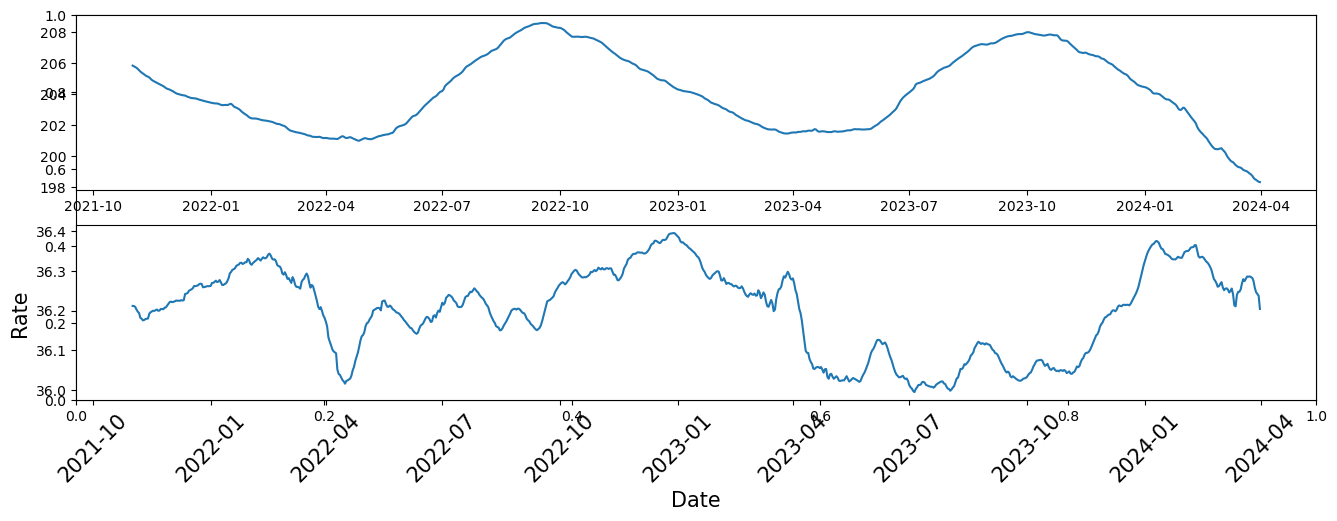

In [48]:
# Adjusting the figure size
fig = plt.subplots(figsize=(16, 5))

plt.subplot(211)
plt.plot(df_test.index, df_test['o2'])

plt.subplot(212)
plt.plot(df_test.index, df_test['Salinity'])

plt.xlabel('Date', fontsize=15)
plt.ylabel('Rate', fontsize=15)

plt.xticks(rotation=45, fontsize=15)

# plt.xlim(pd.Timestamp('2022-01-15'), pd.Timestamp('2023-01-15'))


In [49]:
df_test_1 = df_test.resample('2D').mean()

In [50]:
df_test_1

,lat,lon,o2,Salinity,temp,po4
date,,,,,,
2021-11-01,-10.0,-25.0,205.816393,36.211296,26.504278,NaN
2021-11-03,-10.0,-25.0,205.726522,36.205793,26.507716,NaN
2021-11-05,-10.0,-25.0,205.585491,36.195467,26.551939,NaN
2021-11-07,-10.0,-25.0,205.425824,36.180778,26.546538,NaN
2021-11-09,-10.0,-25.0,205.303568,36.175752,26.567534,NaN
...,...,...,...,...,...,...
2024-03-22,-10.0,-25.0,198.910601,36.285084,29.423716,0.111745
2024-03-24,-10.0,-25.0,198.777680,36.282753,29.443134,0.111275
2024-03-26,-10.0,-25.0,198.562542,36.265589,29.448371,0.111127


(array([18993., 19083., 19174., 19266., 19358., 19448., 19539., 19631.,
        19723., 19814.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04')])

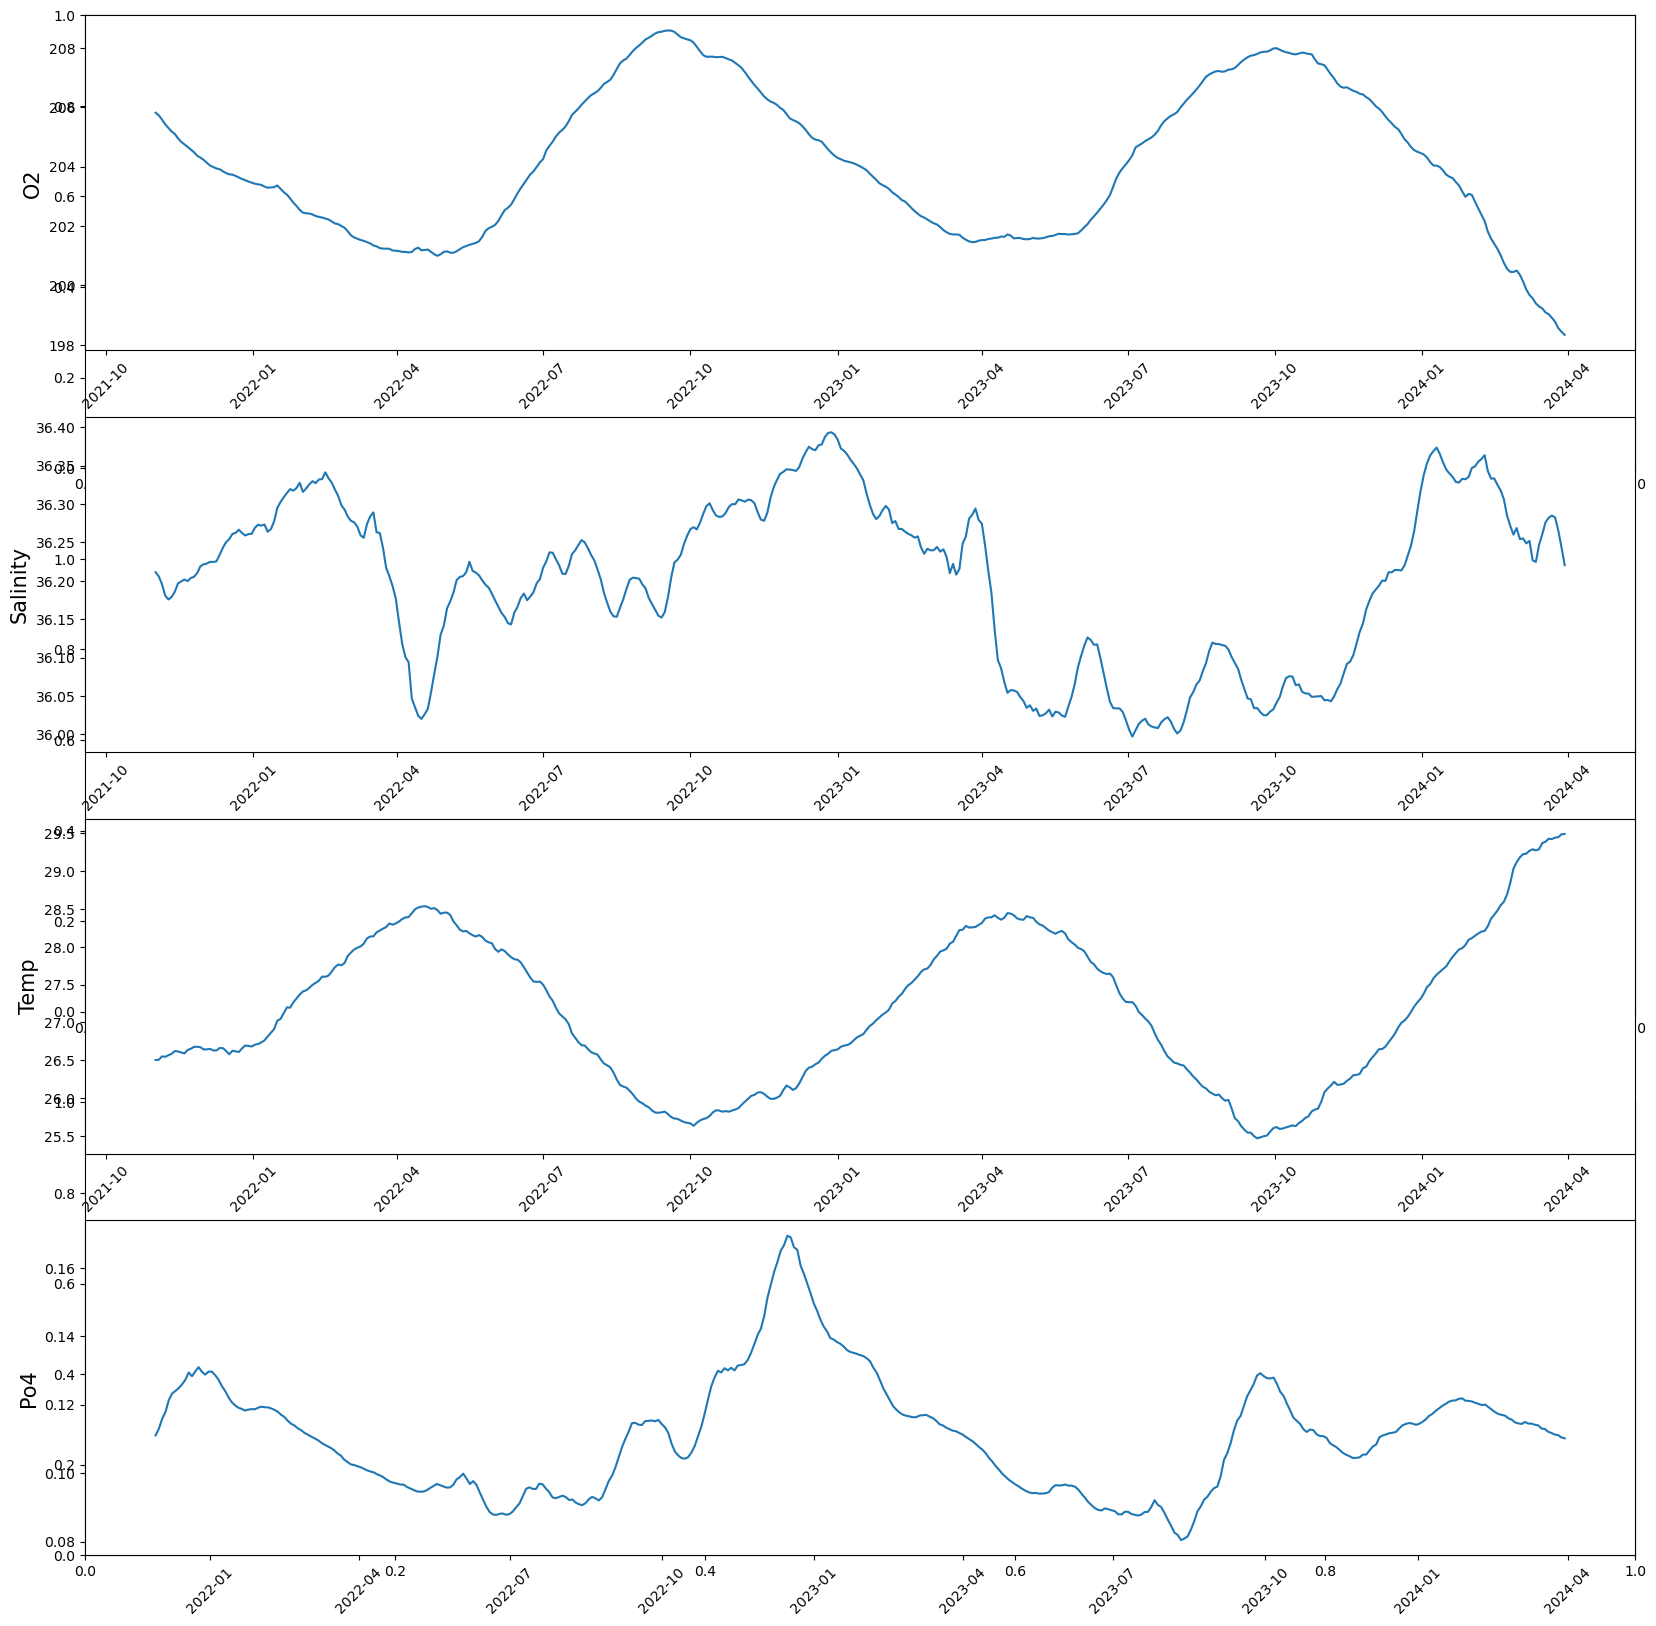

In [97]:
# Adjusting the figure size
fig,axs = plt.subplots(3,1, figsize=(20,20))



plt.subplot(411)
plt.plot(df_test_1.index, df_test_1['o2'])
plt.xticks(rotation=45)


plt.ylabel('O2', fontsize=15)


plt.subplot(412)
plt.plot(df_test_1.index, df_test_1['Salinity'])
plt.xticks(rotation=45)

plt.ylabel('Salinity', fontsize=15)



plt.subplot(413)
plt.plot(df_test_1.index, df_test_1['temp'])
plt.xticks(rotation=45)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temp', fontsize=15)

plt.subplot(414)
plt.plot(df_test_1.index, df_test_1['po4'])

plt.ylabel('Po4', fontsize=15)

plt.xticks(rotation=45)

# plt.xlim(pd.Timestamp('2023-01-15'), pd.Timestamp('2024-04-15'))

# Times Series 

In [78]:
df_all

,lat,lon,o2,Salinity,temp,po4
date,,,,,,
2021-11-01,-15.0,-100.0,NaN,35.626152,21.560081,NaN
2021-11-02,-15.0,-100.0,NaN,35.627741,21.582718,NaN
2021-11-03,-15.0,-100.0,NaN,35.629790,21.594350,NaN
2021-11-04,-15.0,-100.0,NaN,35.629667,21.589084,NaN
2021-11-05,-15.0,-100.0,NaN,35.628391,21.591931,NaN
...,...,...,...,...,...,...
2024-08-21,30.0,-5.0,NaN,NaN,NaN,NaN
2024-08-22,30.0,-5.0,NaN,NaN,NaN,NaN
2024-08-23,30.0,-5.0,NaN,NaN,NaN,NaN


In [81]:
def region_select(df, lat, lon):

    df = df[(df['lon']==lon)& (df['lat']==lat)]
    
    return df 




def apply_model(df, date, lat, lon, params):
    split_date = date

    df_region = region_select(df,lat=lat,lon=lon)

    region_train = df_region.loc[df_region.index <= split_date].copy()
    region_test = df_region.loc[df_region.index > split_date].copy()

    X_train_region = region_train.drop(columns='o2')
    y_train_region = region_train['o2']

    X_test_region = region_test.drop(columns='o2')
    y_test_region = region_test['o2']


    model = xgb.XGBRegressor(
    max_depth=params['max_depth'],  # Maximum depth of a tree
    learning_rate=params['learning_rat:'],  # Learning rate
    n_estimators=params['n_estimators'],  # Number of trees
    subsample=params['subsample'],  # Subsample ratio of the training instances
    colsample_bytree=params['colsample_bytree'],  # Subsample ratio of columns when constructing each tree
    gamma=params['gamma'],  # Minimum loss reduction required to make a further partition
    min_child_weight=params['min_child_weight']  # Minimum sum of instance weight needed in a child
    )



    model.fit(X_train_region, y_train_region,
            eval_set=[(X_train_region, y_train_region), (X_test_region, y_test_region)],
        verbose=True) # Change verbose to True if you want to see it train
    
    y_pred = model.predict(X_test_region)


    mse = mean_squared_error(y_pred,y_test_region)

    rmse = np.sqrt(mse)

    print(f"RMSE : {rmse:.2f}")

    date_range = pd.date_range(date, end='2024-03-31')
    date_range = date_range[1:]

    plt.plot(date_range, y_test_region,label='O2 levels')
    plt.plot(date_range, y_pred, label='Predicted O2 levels')
    plt.legend()
    plt.xticks(rotation=45)

    return model, X_train_region, y_train_region, X_test_region, y_test_region, date_range


In [65]:
df_lag1 = df_all.copy()

for lag in range(1, 2):  # For example, 1 to 3-day lags
    df_lag1[f'Salinity_Lag_{lag}'] = df_lag1['Salinity'].shift(lag)
    df_lag1[f'Temperature_Lag_{lag}'] = df_lag1['temp'].shift(lag)
    df_lag1[f'Phosphate_Lag_{lag}'] = df_lag1['po4'].shift(lag)

# Drop rows with NaN values generated by lagging

df_lag1.dropna(inplace=True)
df_lag1.rename(columns={'temp':'Temperature', 'po4':'Phosphate'}, inplace=True) 
df_lag1

,lat,lon,o2,Salinity,Temperature,Phosphate,Salinity_Lag_1,Temperature_Lag_1,Phosphate_Lag_1
date,,,,,,,,,
2021-12-01,-10.0,-95.0,225.016476,35.309370,22.278105,0.992544,35.304009,22.282107,0.994165
2021-12-02,-10.0,-95.0,225.006230,35.311522,22.260366,0.991536,35.309370,22.278105,0.992544
2021-12-03,-10.0,-95.0,225.010194,35.311226,22.250463,0.990467,35.311522,22.260366,0.991536
2021-12-04,-10.0,-95.0,225.018312,35.311385,22.256994,0.989028,35.311226,22.250463,0.990467
2021-12-05,-10.0,-95.0,225.034223,35.309459,22.304354,0.987759,35.311385,22.256994,0.989028
...,...,...,...,...,...,...,...,...,...
2024-03-27,30.0,-10.0,239.159891,36.328726,17.631023,0.058073,36.325581,17.722586,0.052406
2024-03-28,30.0,-10.0,239.255550,36.331433,17.611179,0.061343,36.328726,17.631023,0.058073
2024-03-29,30.0,-10.0,239.087078,36.327805,17.588211,0.063867,36.331433,17.611179,0.061343


[0]	validation_0-rmse:4.50441	validation_1-rmse:4.93818
[1]	validation_0-rmse:4.13578	validation_1-rmse:4.43998
[2]	validation_0-rmse:3.82058	validation_1-rmse:3.98262
[3]	validation_0-rmse:3.52461	validation_1-rmse:3.51419
[4]	validation_0-rmse:3.26253	validation_1-rmse:3.19587
[5]	validation_0-rmse:3.02604	validation_1-rmse:3.07554
[6]	validation_0-rmse:2.81460	validation_1-rmse:2.91711
[7]	validation_0-rmse:2.63104	validation_1-rmse:2.60667
[8]	validation_0-rmse:2.46975	validation_1-rmse:2.42160
[9]	validation_0-rmse:2.32765	validation_1-rmse:2.30654
[10]	validation_0-rmse:2.19903	validation_1-rmse:2.02630
[11]	validation_0-rmse:2.09160	validation_1-rmse:1.79676
[12]	validation_0-rmse:1.99864	validation_1-rmse:1.69053
[13]	validation_0-rmse:1.91471	validation_1-rmse:1.58293
[14]	validation_0-rmse:1.84488	validation_1-rmse:1.44880
[15]	validation_0-rmse:1.77398	validation_1-rmse:1.38997
[16]	validation_0-rmse:1.71992	validation_1-rmse:1.35160
[17]	validation_0-rmse:1.66800	validation

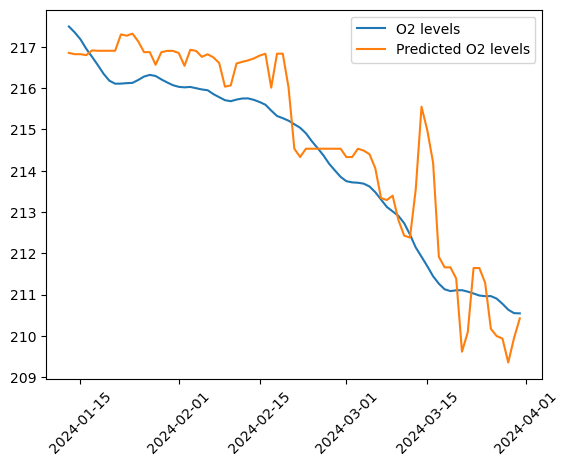

In [82]:
params = { 'max_depth':3,  # Maximum depth of a tree
    'learning_rat:':0.1,  # Learning rate
    'n_estimators' :100,  # Number of trees
    'subsample':0.8,  # Subsample ratio of the training instances
    'colsample_bytree':0.8,  # Subsample ratio of columns when constructing each tree
    'gamma':0,  # Minimum loss reduction required to make a further partition
    'min_child_weight' :1  # Minimum sum of instance weight needed in a child
    }

model_lag1, X_train_region, y_train_region, X_test_region, y_test_region,date_range = apply_model(df_lag1, date='2024-01-12', lat=-10,lon=-95,params=params)

In [67]:
import shap
import tqdm as notebook_tqdm
# Explain the model's predictions using SHAP

# The 'explainer' allows you to connect to your trained model and compute / retrieve its SHAP values, regardless of the underlying model type!

explainer = shap.TreeExplainer(model_lag1, X_train_region)
shap_values = explainer(X_test_region)


# Create an "Explanation" SHAP object;

# This is simply an 'all - encompassing' data structure in SHAP that contains the SHAP values, base values, input feature data, feature names, and some additional
# information about the model / computations that may be needed by some plotting functions for more advanced visualizations

shap_values_explanation = shap.Explanation(shap_values.values, base_values=shap_values.base_values, data=X_test_region, feature_names=X_test_region.columns)

# The shap.initjs() function is used here to initialize JavaScript visualizations for our SHAP plots
shap.initjs()

In [68]:
shap.plots.force(explainer.expected_value, shap_values[0].values, X_test_region.iloc[0, :])

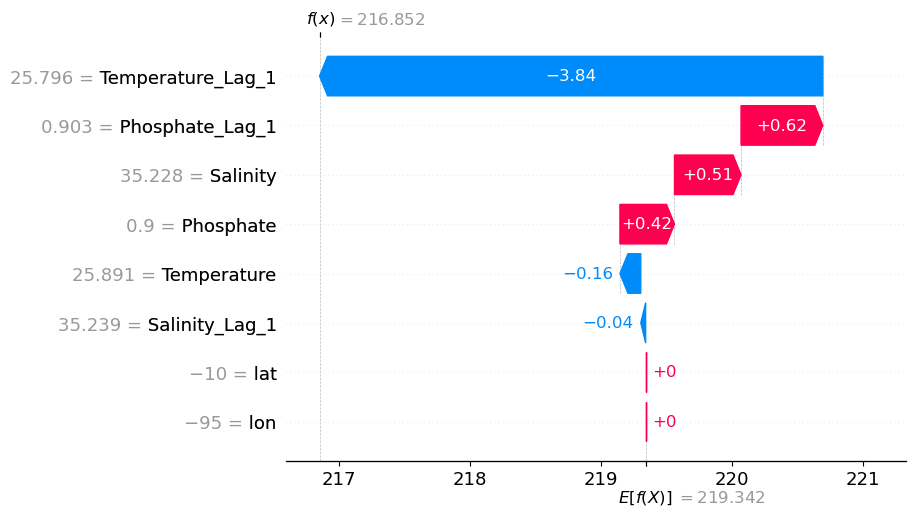

In [69]:
# Waterfall plot for a first instance
shap.waterfall_plot(shap_values_explanation[0])
plt.show()

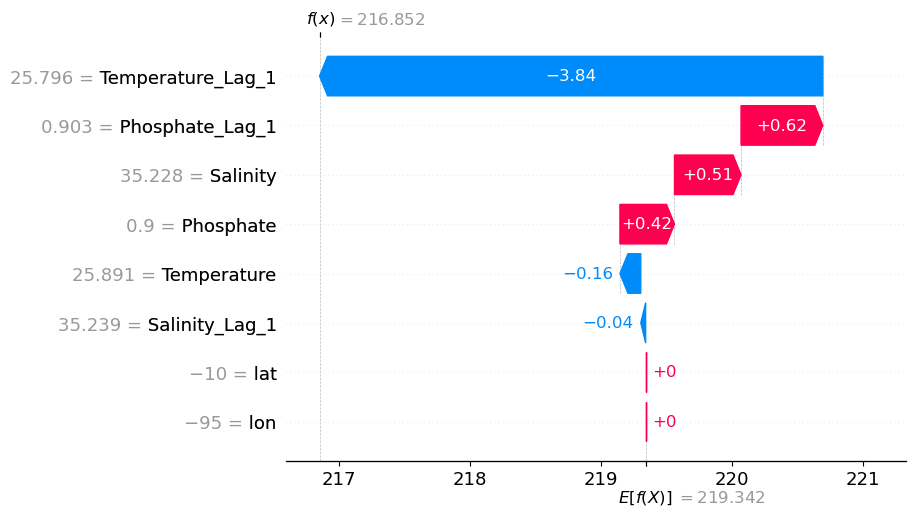

In [70]:
# Waterfall plot for a first instance
shap.waterfall_plot(shap_values_explanation[0])
plt.show()

In [71]:
# Create lagged features
df_lag3 = df_all.copy()

for lag in range(1, 4):  # For example, 1 to 3-day lags
    df_lag3[f'Salinity_Lag_{lag}'] = df_lag3['Salinity'].shift(lag)
    df_lag3[f'Temperature_Lag_{lag}'] = df_lag3['temp'].shift(lag)
    df_lag3[f'Phosphate_Lag_{lag}'] = df_lag3['po4'].shift(lag)

# Drop rows with NaN values generated by lagging

df_lag3.dropna(inplace=True)
df_lag3.rename(columns={'temp':'Temperature', 'po4':'Phosphate'}, inplace=True) 
df_lag3

,lat,lon,o2,Salinity,Temperature,Phosphate,Salinity_Lag_1,Temperature_Lag_1,Phosphate_Lag_1,Salinity_Lag_2,Temperature_Lag_2,Phosphate_Lag_2,Salinity_Lag_3,Temperature_Lag_3,Phosphate_Lag_3
date,,,,,,,,,,,,,,,
2021-12-03,-10.0,-95.0,225.010194,35.311226,22.250463,0.990467,35.311522,22.260366,0.991536,35.309370,22.278105,0.992544,35.304009,22.282107,0.994165
2021-12-04,-10.0,-95.0,225.018312,35.311385,22.256994,0.989028,35.311226,22.250463,0.990467,35.311522,22.260366,0.991536,35.309370,22.278105,0.992544
2021-12-05,-10.0,-95.0,225.034223,35.309459,22.304354,0.987759,35.311385,22.256994,0.989028,35.311226,22.250463,0.990467,35.311522,22.260366,0.991536
2021-12-06,-10.0,-95.0,225.039813,35.308527,22.286987,0.986483,35.309459,22.304354,0.987759,35.311385,22.256994,0.989028,35.311226,22.250463,0.990467
2021-12-07,-10.0,-95.0,225.038898,35.308084,22.285258,0.984619,35.308527,22.286987,0.986483,35.309459,22.304354,0.987759,35.311385,22.256994,0.989028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,30.0,-10.0,239.159891,36.328726,17.631023,0.058073,36.325581,17.722586,0.052406,36.321904,17.841747,0.044327,36.316676,17.879458,0.041108
2024-03-28,30.0,-10.0,239.255550,36.331433,17.611179,0.061343,36.328726,17.631023,0.058073,36.325581,17.722586,0.052406,36.321904,17.841747,0.044327
2024-03-29,30.0,-10.0,239.087078,36.327805,17.588211,0.063867,36.331433,17.611179,0.061343,36.328726,17.631023,0.058073,36.325581,17.722586,0.052406


[0]	validation_0-rmse:4.49736	validation_1-rmse:4.98806
[1]	validation_0-rmse:4.12000	validation_1-rmse:4.44431
[2]	validation_0-rmse:3.79213	validation_1-rmse:4.16062
[3]	validation_0-rmse:3.49147	validation_1-rmse:3.68805
[4]	validation_0-rmse:3.21759	validation_1-rmse:3.39259
[5]	validation_0-rmse:2.97599	validation_1-rmse:3.03768
[6]	validation_0-rmse:2.75976	validation_1-rmse:2.78805
[7]	validation_0-rmse:2.56979	validation_1-rmse:2.44451
[8]	validation_0-rmse:2.40670	validation_1-rmse:2.14396
[9]	validation_0-rmse:2.25869	validation_1-rmse:2.04964
[10]	validation_0-rmse:2.12703	validation_1-rmse:1.80314
[11]	validation_0-rmse:2.01436	validation_1-rmse:1.69131
[12]	validation_0-rmse:1.91226	validation_1-rmse:1.57347
[13]	validation_0-rmse:1.82249	validation_1-rmse:1.47388
[14]	validation_0-rmse:1.74753	validation_1-rmse:1.40393
[15]	validation_0-rmse:1.67196	validation_1-rmse:1.32959
[16]	validation_0-rmse:1.61417	validation_1-rmse:1.26290
[17]	validation_0-rmse:1.56015	validation

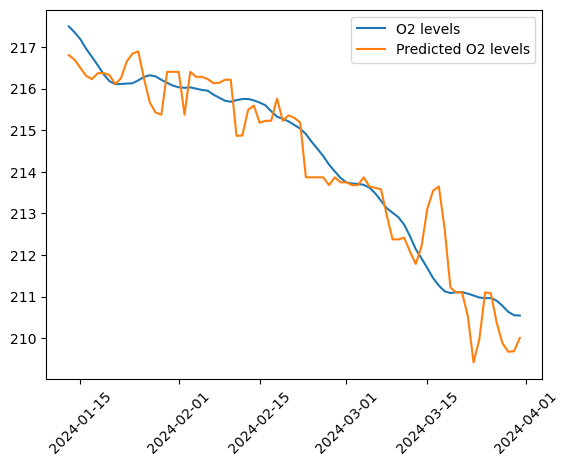

In [83]:


params = { 'max_depth':3,  # Maximum depth of a tree
    'learning_rat:':0.1,  # Learning rate
    'n_estimators' :100,  # Number of trees
    'subsample':0.8,  # Subsample ratio of the training instances
    'colsample_bytree':0.8,  # Subsample ratio of columns when constructing each tree
    'gamma':0,  # Minimum loss reduction required to make a further partition
    'min_child_weight' :1  # Minimum sum of instance weight needed in a child
    }


        
    
model_lag3, X_train_region, y_train_region, X_test_region, y_test_region,date_range = apply_model(df_lag3, date='2024-01-12', lat=-10,lon=-95,params=params)


In [62]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid to search over
# param_grid = {
#     'max_depth': [3, 5, 10, 50,100],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200],
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=model_lag3, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# # Fit the grid search to the training data
# grid_search.fit(X_train_region, y_train_region)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# # Create a new model with the best parameters
# best_model = xgb.XGBRegressor(**best_params)

# # Train the best model
# best_model.fit(X_train_region, y_train_region)

# # Make predictions on the test set
# y_pred_best = best_model.predict(X_test_region)

# # Evaluate the best model
# # accuracy_best = (y_pred_best == y_test).mean()
# # Evaluate the model (example using accuracy)
# mse = mean_squared_error(y_pred_best,y_test_region)

# rmse = np.sqrt(mse)


# # print(f"Rmse: {rmse:.2f}")
# print(f"RMSE with Best Parameters: {rmse:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE with Best Parameters: 0.99


NameError: name 'y_pred_best' is not defined

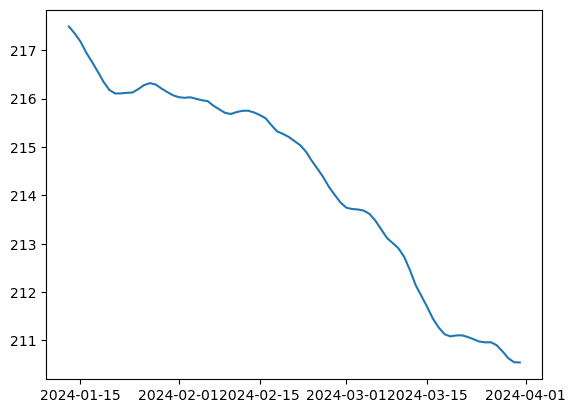

In [62]:
# plt.plot(date_range, y_test_region, label='O2 level')
# plt.plot(date_range, y_pred_best, label='Predicted O2 level')
# plt.legend()

In [73]:
import shap
import tqdm as notebook_tqdm
# Explain the model's predictions using SHAP

# The 'explainer' allows you to connect to your trained model and compute / retrieve its SHAP values, regardless of the underlying model type!

explainer = shap.TreeExplainer(model_lag3, X_train_region)
shap_values = explainer(X_test_region)


# Create an "Explanation" SHAP object;

# This is simply an 'all - encompassing' data structure in SHAP that contains the SHAP values, base values, input feature data, feature names, and some additional
# information about the model / computations that may be needed by some plotting functions for more advanced visualizations

shap_values_explanation = shap.Explanation(shap_values.values, base_values=shap_values.base_values, data=X_test_region, feature_names=X_test_region.columns)

# The shap.initjs() function is used here to initialize JavaScript visualizations for our SHAP plots
shap.initjs()

In [74]:
shap.plots.force(explainer.expected_value, shap_values[0].values, X_test_region.iloc[0, :])

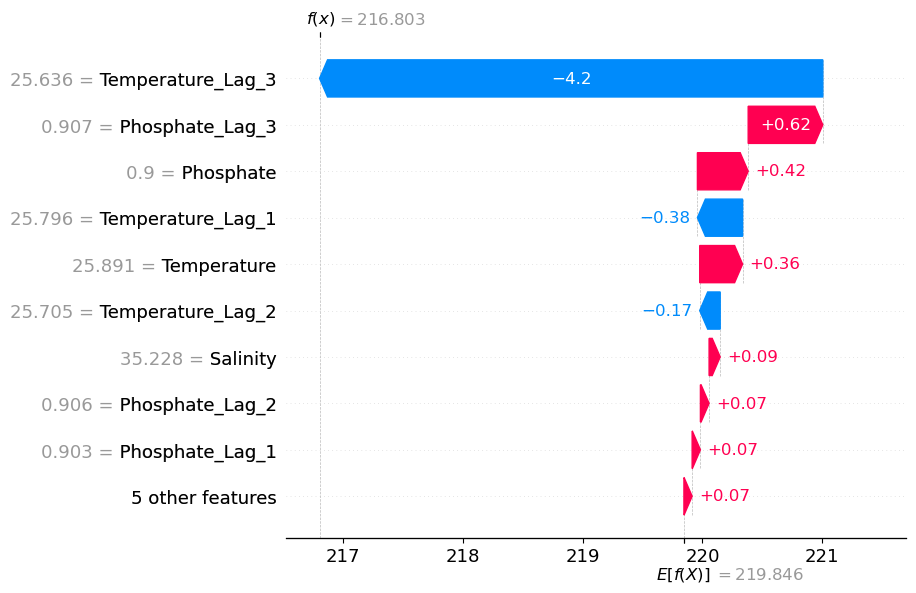

In [75]:
# Waterfall plot for a first instance
shap.waterfall_plot(shap_values_explanation[0])
plt.show()

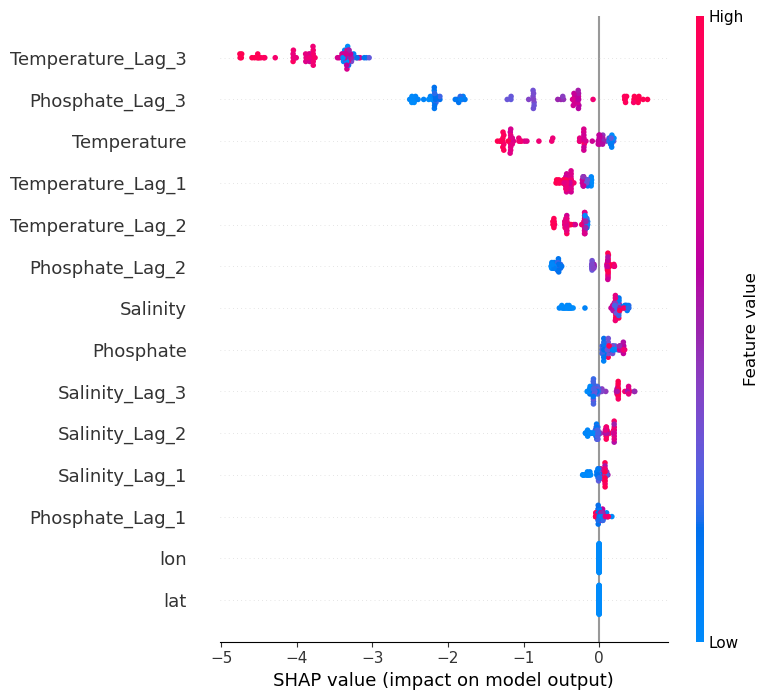

In [ ]:
shap.summary_plot(shap_values, X_test_region)

# More lag

In [84]:
df_lag30 = df_all.copy()
# Create lagged features
for lag in range(1, 31):  # For example, 1 to 3-day lags
    df_lag30[f'Salinity_Lag_{lag}'] = df_lag30['Salinity'].shift(lag)
    df_lag30[f'Temperature_Lag_{lag}'] = df_lag30['temp'].shift(lag)
    df_lag30[f'Phosphate_Lag_{lag}'] = df_lag30['po4'].shift(lag)

# Drop rows with NaN values generated by lagging


df_lag30.dropna(inplace=True)
df_lag30.rename(columns={'temp':'Temperature', 'po4':'Phosphate'}, inplace=True) 
df_lag30

,lat,lon,o2,Salinity,Temperature,Phosphate,Salinity_Lag_1,Temperature_Lag_1,Phosphate_Lag_1,Salinity_Lag_2,...,Phosphate_Lag_27,Salinity_Lag_28,Temperature_Lag_28,Phosphate_Lag_28,Salinity_Lag_29,Temperature_Lag_29,Phosphate_Lag_29,Salinity_Lag_30,Temperature_Lag_30,Phosphate_Lag_30
date,,,,,,,,,,,,,,,,,,,,,
2021-12-30,-10.0,-95.0,224.705418,35.255555,22.492097,0.941231,35.256184,22.472290,0.943217,35.262801,...,0.990467,35.311522,22.260366,0.991536,35.309370,22.278105,0.992544,35.304009,22.282107,0.994165
2021-12-31,-10.0,-95.0,224.639708,35.259081,22.504261,0.939080,35.255555,22.492097,0.941231,35.256184,...,0.989028,35.311226,22.250463,0.990467,35.311522,22.260366,0.991536,35.309370,22.278105,0.992544
2022-01-01,-10.0,-95.0,224.584190,35.260531,22.517564,0.938046,35.259081,22.504261,0.939080,35.255555,...,0.987759,35.311385,22.256994,0.989028,35.311226,22.250463,0.990467,35.311522,22.260366,0.991536
2022-01-02,-10.0,-95.0,224.558103,35.262844,22.559637,0.937285,35.260531,22.517564,0.938046,35.259081,...,0.986483,35.309459,22.304354,0.987759,35.311385,22.256994,0.989028,35.311226,22.250463,0.990467
2022-01-03,-10.0,-95.0,224.525379,35.261140,22.611469,0.934998,35.262844,22.559637,0.937285,35.260531,...,0.984619,35.308527,22.286987,0.986483,35.309459,22.304354,0.987759,35.311385,22.256994,0.989028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,30.0,-10.0,239.159891,36.328726,17.631023,0.058073,36.325581,17.722586,0.052406,36.321904,...,0.047961,36.252535,18.003225,0.047875,36.243044,18.090335,0.046913,36.231194,18.225435,0.042148
2024-03-28,30.0,-10.0,239.255550,36.331433,17.611179,0.061343,36.328726,17.631023,0.058073,36.325581,...,0.050605,36.260482,17.947972,0.047961,36.252535,18.003225,0.047875,36.243044,18.090335,0.046913
2024-03-29,30.0,-10.0,239.087078,36.327805,17.588211,0.063867,36.331433,17.611179,0.061343,36.328726,...,0.051687,36.267806,17.854644,0.050605,36.260482,17.947972,0.047961,36.252535,18.003225,0.047875


[0]	validation_0-rmse:4.46863	validation_1-rmse:4.73925
[1]	validation_0-rmse:4.05147	validation_1-rmse:4.47410
[2]	validation_0-rmse:3.67845	validation_1-rmse:4.24494
[3]	validation_0-rmse:3.34405	validation_1-rmse:3.83199
[4]	validation_0-rmse:3.04355	validation_1-rmse:3.37034
[5]	validation_0-rmse:2.77226	validation_1-rmse:3.16841
[6]	validation_0-rmse:2.52327	validation_1-rmse:2.78693
[7]	validation_0-rmse:2.29559	validation_1-rmse:2.61585
[8]	validation_0-rmse:2.09230	validation_1-rmse:2.49947
[9]	validation_0-rmse:1.90748	validation_1-rmse:2.44612
[10]	validation_0-rmse:1.73993	validation_1-rmse:2.23648
[11]	validation_0-rmse:1.59309	validation_1-rmse:2.01106
[12]	validation_0-rmse:1.45696	validation_1-rmse:1.84983
[13]	validation_0-rmse:1.33318	validation_1-rmse:1.73454
[14]	validation_0-rmse:1.22031	validation_1-rmse:1.63475
[15]	validation_0-rmse:1.11666	validation_1-rmse:1.61259
[16]	validation_0-rmse:1.02950	validation_1-rmse:1.50675
[17]	validation_0-rmse:0.94865	validation

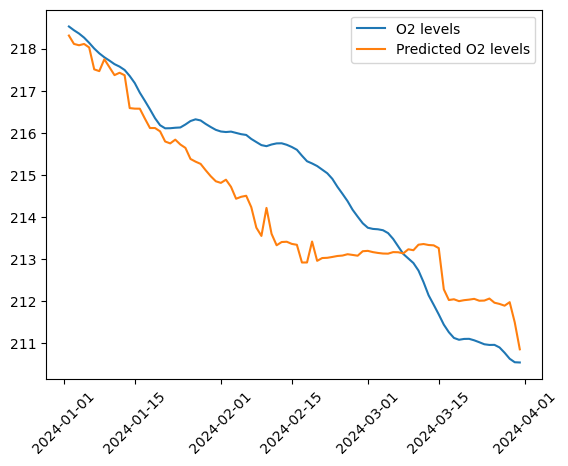

In [95]:
    
params = { 'max_depth':3,  # Maximum depth of a tree
    'learning_rat:':0.1,  # Learning rate
    'n_estimators' :800,  # Number of trees
    'subsample':0.8,  # Subsample ratio of the training instances
    'colsample_bytree':0.8,  # Subsample ratio of columns when constructing each tree
    'gamma':0,  # Minimum loss reduction required to make a further partition
    'min_child_weight' :1  # Minimum sum of instance weight needed in a child
    }



model_lag30, X_train_region2, y_train_region2, X_test_region2, y_test_region2,date_range = apply_model(df_lag30, date='2024-01-01', lat=-10,lon=-95,params=params)

In [84]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid to search over
# param_grid = {
#     'max_depth': [5, 10, 50,100],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# # Create a GridSearchCV object
# grid_search2 = GridSearchCV(estimator=model2, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# # Fit the grid search to the training data
# grid_search2.fit(X_train_region2, y_train_region2)

# # Get the best parameters
# best_params2 = grid_search2.best_params_
# print(f"Best Parameters: {best_params}")

# # Create a new model with the best parameters
# best_model2 = xgb.XGBRegressor(**best_params2)

# # Train the best model
# best_model2.fit(X_train_region2, y_train_region2)

# # Make predictions on the test set
# y_pred_best2 = best_model2.predict(X_test_region2)

# # Evaluate the best model
# # accuracy_best = (y_pred_best == y_test).mean()
# # Evaluate the model (example using accuracy)
# mse2 = mean_squared_error(y_pred_best2,y_test_region2)

# rmse2 = np.sqrt(mse2)


# # print(f"Rmse: {rmse:.2f}")
# print(f"RMSE with Best Parameters: {rmse2:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE with Best Parameters: 1.28


In [86]:
import shap
# Explain the model's predictions using SHAP

# The 'explainer' allows you to connect to your trained model and compute / retrieve its SHAP values, regardless of the underlying model type!

explainer = shap.TreeExplainer(model_lag30, X_train_region2)
shap_values = explainer(X_test_region2)


# Create an "Explanation" SHAP object;

# This is simply an 'all - encompassing' data structure in SHAP that contains the SHAP values, base values, input feature data, feature names, and some additional
# information about the model / computations that may be needed by some plotting functions for more advanced visualizations

shap_values_explanation = shap.Explanation(shap_values.values, base_values=shap_values.base_values, data=X_test_region2, feature_names=X_test_region2.columns)

# The shap.initjs() function is used here to initialize JavaScript visualizations for our SHAP plots
shap.initjs()

In [87]:
shap.plots.force(explainer.expected_value, shap_values[0].values, X_test_region2.iloc[0, :])

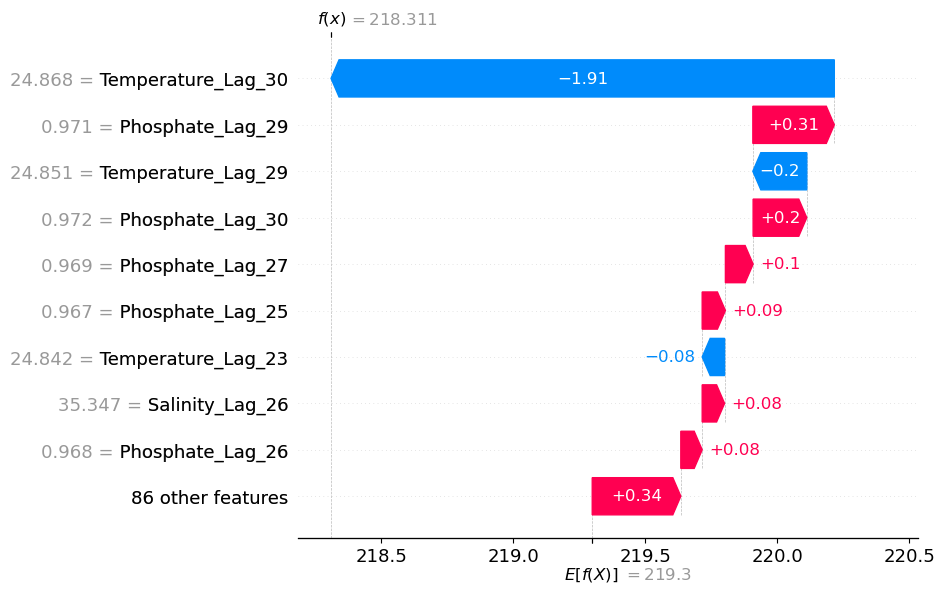

In [88]:
# Waterfall plot for a first instance
shap.waterfall_plot(shap_values_explanation[0])
plt.show()

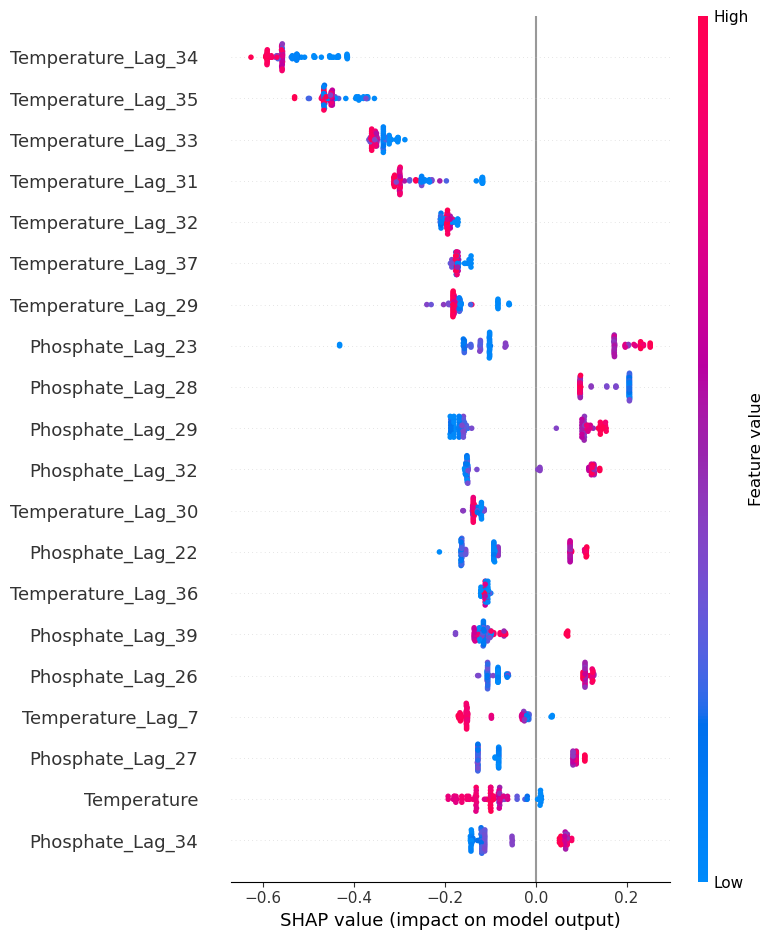

In [91]:
shap.summary_plot(shap_values, X_test_region2)

In [92]:
# Create lagged features

df_lag60 = df_all.copy()

for lag in range(1, 61):  # For example, 1 to 3-day lags
    df_lag60[f'Salinity_Lag_{lag}'] = df_lag60['Salinity'].shift(lag)
    df_lag60[f'Temperature_Lag_{lag}'] = df_lag60['temp'].shift(lag)
    df_lag60[f'Phosphate_Lag_{lag}'] = df_lag60['po4'].shift(lag)

# Drop rows with NaN values generated by lagging


df_lag60.dropna(inplace=True)
df_lag60.rename(columns={'temp':'Temperature', 'po4':'Phosphate'}, inplace=True) 
df_lag60

/var/folders/hr/s8vh2tdj11s6hjxcsw2lr01m0000gn/T/ipykernel_39892/16658262.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lag60[f'Salinity_Lag_{lag}'] = df_lag60['Salinity'].shift(lag)
/var/folders/hr/s8vh2tdj11s6hjxcsw2lr01m0000gn/T/ipykernel_39892/16658262.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lag60[f'Temperature_Lag_{lag}'] = df_lag60['temp'].shift(lag)
/var/folders/hr/s8vh2tdj11s6hjxcsw2lr01m0000gn/T/ipykernel_39892/16658262.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

,lat,lon,o2,Salinity,Temperature,Phosphate,Salinity_Lag_1,Temperature_Lag_1,Phosphate_Lag_1,Salinity_Lag_2,...,Phosphate_Lag_57,Salinity_Lag_58,Temperature_Lag_58,Phosphate_Lag_58,Salinity_Lag_59,Temperature_Lag_59,Phosphate_Lag_59,Salinity_Lag_60,Temperature_Lag_60,Phosphate_Lag_60
date,,,,,,,,,,,,,,,,,,,,,
2022-01-29,-10.0,-95.0,222.280910,35.310822,23.742696,0.900987,35.307088,23.706264,0.902185,35.304187,...,0.990467,35.311522,22.260366,0.991536,35.309370,22.278105,0.992544,35.304009,22.282107,0.994165
2022-01-30,-10.0,-95.0,222.223389,35.313583,23.748031,0.901941,35.310822,23.742696,0.900987,35.307088,...,0.989028,35.311226,22.250463,0.990467,35.311522,22.260366,0.991536,35.309370,22.278105,0.992544
2022-01-31,-10.0,-95.0,222.137967,35.313318,23.759220,0.903132,35.313583,23.748031,0.901941,35.310822,...,0.987759,35.311385,22.256994,0.989028,35.311226,22.250463,0.990467,35.311522,22.260366,0.991536
2022-02-01,-10.0,-95.0,222.064549,35.310458,23.795469,0.903511,35.313318,23.759220,0.903132,35.313583,...,0.986483,35.309459,22.304354,0.987759,35.311385,22.256994,0.989028,35.311226,22.250463,0.990467
2022-02-02,-10.0,-95.0,222.038366,35.306499,23.851806,0.902390,35.310458,23.795469,0.903511,35.313318,...,0.984619,35.308527,22.286987,0.986483,35.309459,22.304354,0.987759,35.311385,22.256994,0.989028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,30.0,-10.0,239.159891,36.328726,17.631023,0.058073,36.325581,17.722586,0.052406,36.321904,...,0.038379,36.379285,18.611779,0.038506,36.392475,18.615987,0.038610,36.405639,18.617934,0.038923
2024-03-28,30.0,-10.0,239.255550,36.331433,17.611179,0.061343,36.328726,17.631023,0.058073,36.325581,...,0.038291,36.366269,18.605272,0.038379,36.379285,18.611779,0.038506,36.392475,18.615987,0.038610
2024-03-29,30.0,-10.0,239.087078,36.327805,17.588211,0.063867,36.331433,17.611179,0.061343,36.328726,...,0.038357,36.353603,18.587055,0.038291,36.366269,18.605272,0.038379,36.379285,18.611779,0.038506


[0]	validation_0-rmse:4.44587	validation_1-rmse:4.84249
[1]	validation_0-rmse:4.03185	validation_1-rmse:4.60413
[2]	validation_0-rmse:3.65769	validation_1-rmse:4.37050
[3]	validation_0-rmse:3.31418	validation_1-rmse:4.10561
[4]	validation_0-rmse:3.01407	validation_1-rmse:3.74470
[5]	validation_0-rmse:2.73222	validation_1-rmse:3.55052
[6]	validation_0-rmse:2.48941	validation_1-rmse:3.21644
[7]	validation_0-rmse:2.26114	validation_1-rmse:3.04437
[8]	validation_0-rmse:2.06070	validation_1-rmse:2.67874
[9]	validation_0-rmse:1.87966	validation_1-rmse:2.39036
[10]	validation_0-rmse:1.70974	validation_1-rmse:2.13507
[11]	validation_0-rmse:1.55190	validation_1-rmse:2.10227
[12]	validation_0-rmse:1.41229	validation_1-rmse:2.08763
[13]	validation_0-rmse:1.28760	validation_1-rmse:1.98444
[14]	validation_0-rmse:1.17363	validation_1-rmse:1.92869
[15]	validation_0-rmse:1.07194	validation_1-rmse:1.84449
[16]	validation_0-rmse:0.98019	validation_1-rmse:1.73579
[17]	validation_0-rmse:0.89693	validation

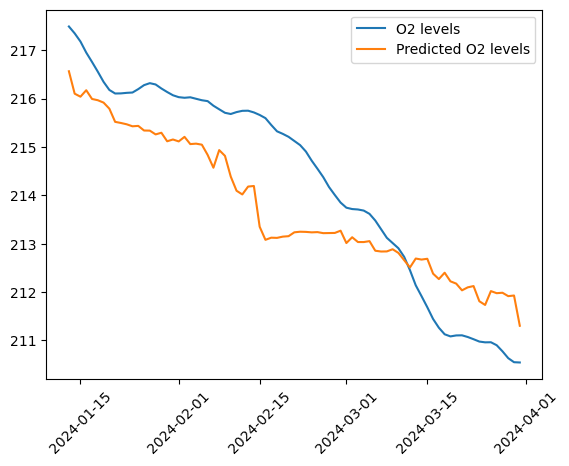

In [93]:
params = { 'max_depth':3,  # Maximum depth of a tree
    'learning_rat:':0.1,  # Learning rate
    'n_estimators' :800,  # Number of trees
    'subsample':0.8,  # Subsample ratio of the training instances
    'colsample_bytree':0.8,  # Subsample ratio of columns when constructing each tree
    'gamma':0,  # Minimum loss reduction required to make a further partition
    'min_child_weight' :1  # Minimum sum of instance weight needed in a child
    }

model_lag60, X_train_region2, y_train_region2, X_test_region2, y_test_region2,date_range = apply_model(df_lag60, date='2024-01-12', lat=-10,lon=-95, params=params)

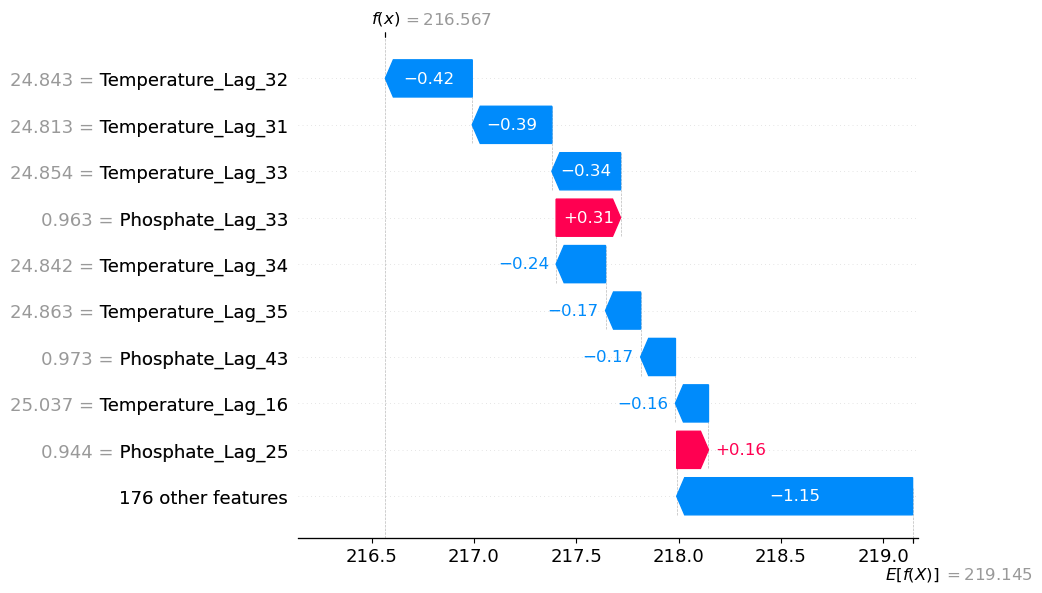

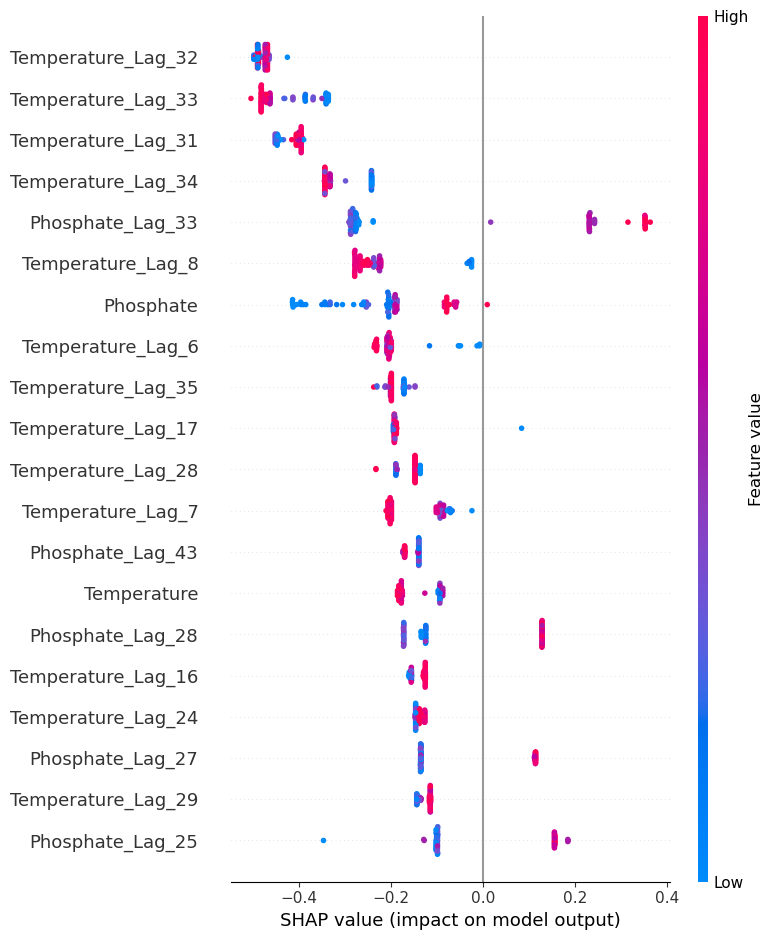

In [94]:


# # Define the parameter grid to search over
# param_grid = {
#     'max_depth': [3, 5, 10, 50,100],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# # Create a GridSearchCV object
# grid_search2 = GridSearchCV(estimator=model2, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# # Fit the grid search to the training data
# grid_search2.fit(X_train_region2, y_train_region2)

# # Get the best parameters
# best_params2 = grid_search2.best_params_
# print(f"Best Parameters: {best_params}")

# # Create a new model with the best parameters
# best_model2 = xgb.XGBRegressor(**best_params2)

# # Train the best model
# best_model2.fit(X_train_region2, y_train_region2)

# # Make predictions on the test set
# y_pred_best2 = best_model2.predict(X_test_region2)

# # Evaluate the best model
# # accuracy_best = (y_pred_best == y_test).mean()
# # Evaluate the model (example using accuracy)
# mse2 = mean_squared_error(y_pred_best2,y_test_region2)

# rmse2 = np.sqrt(mse2)


# # print(f"Rmse: {rmse:.2f}")
# print(f"RMSE with Best Parameters: {rmse2:.2f}")



# # Waterfall plot for a first instance


# Explain the model's predictions using SHAP

# The 'explainer' allows you to connect to your trained model and compute / retrieve its SHAP values, regardless of the underlying model type!

explainer = shap.TreeExplainer(model_lag60, X_train_region2)
shap_values = explainer(X_test_region2)


# Create an "Explanation" SHAP object;

# This is simply an 'all - encompassing' data structure in SHAP that contains the SHAP values, base values, input feature data, feature names, and some additional
# information about the model / computations that may be needed by some plotting functions for more advanced visualizations

shap_values_explanation = shap.Explanation(shap_values.values, base_values=shap_values.base_values, data=X_test_region2, feature_names=X_test_region2.columns)

# The shap.initjs() function is used here to initialize JavaScript visualizations for our SHAP plots
shap.initjs()

shap.plots.force(explainer.expected_value, shap_values[0].values, X_test_region2.iloc[0, :])
shap.waterfall_plot(shap_values_explanation[0])
plt.show()
shap.summary_plot(shap_values, X_test_region2)

[0]	validation_0-rmse:4.54093	validation_1-rmse:4.77946
[1]	validation_0-rmse:4.11510	validation_1-rmse:4.54033
[2]	validation_0-rmse:3.73246	validation_1-rmse:4.28832
[3]	validation_0-rmse:3.38380	validation_1-rmse:4.07727
[4]	validation_0-rmse:3.06565	validation_1-rmse:3.87203
[5]	validation_0-rmse:2.77581	validation_1-rmse:3.65057
[6]	validation_0-rmse:2.51934	validation_1-rmse:3.48225
[7]	validation_0-rmse:2.29234	validation_1-rmse:3.17733
[8]	validation_0-rmse:2.08185	validation_1-rmse:3.06048
[9]	validation_0-rmse:1.89195	validation_1-rmse:2.87150
[10]	validation_0-rmse:1.72841	validation_1-rmse:2.59766
[11]	validation_0-rmse:1.57078	validation_1-rmse:2.48389
[12]	validation_0-rmse:1.42881	validation_1-rmse:2.37015
[13]	validation_0-rmse:1.30361	validation_1-rmse:2.27311
[14]	validation_0-rmse:1.19316	validation_1-rmse:2.10667
[15]	validation_0-rmse:1.09374	validation_1-rmse:1.97601
[16]	validation_0-rmse:0.99934	validation_1-rmse:1.91492
[17]	validation_0-rmse:0.91424	validation

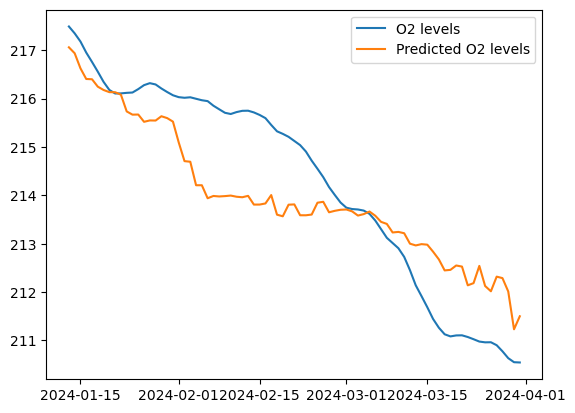

In [99]:

params2 = { 'max_depth':3,  # Maximum depth of a tree
    'learning_rat:':0.1,  # Learning rate
    'n_estimators' :800,  # Number of trees
    'subsample':0.8,  # Subsample ratio of the training instances
    'colsample_bytree':0.8,  # Subsample ratio of columns when constructing each tree
    'gamma':0,  # Minimum loss reduction required to make a further partition
    'min_child_weight' :1  # Minimum sum of instance weight needed in a child
    }

model2, X_train_region2, y_train_region2, X_test_region2, y_test_region2,date_range = apply_model(df_lag60, date='2024-01-12', lat=-10,lon=-95,params=params2)